# Text to SQL with Claude

## Introduction

Text to SQL is a natural language processing task that converts human-readable text queries into structured SQL queries. This lets users interact with databases using natural language. 

Claude can understand context, interpret complex queries, and generate accurate SQL statements. This guide focuses on using Claude to build a robust Text to SQL system.

## Why is Text to SQL Useful?

Text to SQL is valuable for several reasons:

1. **Accessibility**: Non-technical users can query databases without knowing SQL syntax, making data access easier within organizations.

2. **Efficiency**: Data analysts and scientists can quickly prototype queries using natural language.

3. **Integration**: It enables more intuitive interfaces for database interactions in applications and chatbots.

4. **Complex Query Generation**: LLMs can generate complex SQL queries involving multiple joins, subqueries, and aggregations, which can be time-consuming for humans to write.

## What This Guide Covers

This guide will walk you through building a Text to SQL system using LLMs. We'll cover:

1. Setting up a test SQLite database
2. Effective prompting for Text to SQL conversion
3. RAG (Retrieval Augmented Generation) to handle more complex database systems
4. Self-improvement and iteration of Claude's outputs
5. Evaluations

By the end of this guide, you'll understand how to implement and refine Text to SQL tasks using Claude, and have a framework for applying these techniques to your own projects.

## Table of Contents

1. [Introduction](#introduction)
2. [Setup](#setup)
3. [Creating a Basic Text to SQL Prompt](#creating-a-basic-text-to-sql-prompt)
4. [Improving the Prompt with Examples](#improving-the-prompt-with-examples)
5. [Using Chain-of-Thought Prompting](#using-chain-of-thought-prompting)
6. [Implementing RAG for Complex Database Schemas](#implementing-rag-for-complex-database-schemas)
7. [Implementing Query Self-Improvement](#implementing-query-self-improvement)
8. [Evaluations](#evaluations)
9. [Further Exploration & Next Steps](#further-exploration--next-steps)

## Setup

Let's set up our environment and create a test SQLite database with two tables: `employees` and `departments`. We'll use this database throughout our guide.

In [2]:
%pip install -q anthropic pandas voyageai matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from anthropic import Anthropic
import sqlite3
import pandas as pd
from IPython.display import display

# Set your Anthropic API key
os.environ["ANTHROPIC_API_KEY"] = "YOUR_ANTHROPIC_API_KEY"
os.environ["VOYAGE_API_KEY"] = "YOUR_VOYAGE_API_KEY"

# Initialize the Anthropic client
client = Anthropic()
MODEL_NAME = "claude-3-5-sonnet-20241022"

# Filepath to the SQLite database
DATABASE_PATH = "data/data.db"

### Create a Test Database

In [4]:
import random
from datetime import datetime, timedelta

if not os.path.exists(DATABASE_PATH):
    print("Database does not exist. Creating and populating...")
    # Create a new SQLite database and tables
    with sqlite3.connect(DATABASE_PATH) as conn:
        cursor = conn.cursor()
        
        cursor.executescript('''
        CREATE TABLE IF NOT EXISTS departments (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            location TEXT
        );
        CREATE TABLE IF NOT EXISTS employees (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            age INTEGER,
            department_id INTEGER,
            salary REAL,
            hire_date DATE,
            FOREIGN KEY (department_id) REFERENCES departments (id)
        );
        ''')

        # Insert sample data
        cursor.executemany('INSERT INTO departments VALUES (?,?,?)',
            [
                (1, 'HR', 'New York'), 
                (2, 'Engineering', 'San Francisco'), 
                (3, 'Marketing', 'Chicago'),
                (4, 'Sales', 'Los Angeles'),
                (5, 'Finance', 'Boston'),
                (6, 'Customer Support', 'Dallas'),
                (7, 'Research', 'Seattle'),
                (8, 'Legal', 'Washington D.C.'),
                (9, 'Product', 'Austin'),
                (10, 'Operations', 'Denver')
            ])
        
        first_names = ['John', 'Jane', 'Bob', 'Alice', 'Charlie', 'Diana', 'Edward', 'Fiona', 'George', 'Hannah', 'Ian', 'Julia', 'Kevin', 'Laura', 'Michael', 'Nora', 'Oliver', 'Patricia', 'Quentin', 'Rachel', 'Steve', 'Tina', 'Ulysses', 'Victoria', 'William', 'Xena', 'Yannick', 'Zoe']
        last_names = ['Smith', 'Johnson', 'Williams', 'Jones', 'Brown', 'Davis', 'Miller', 'Wilson', 'Moore', 'Taylor', 'Anderson', 'Thomas', 'Jackson', 'White', 'Harris', 'Martin', 'Thompson', 'Garcia', 'Martinez', 'Robinson', 'Clark', 'Rodriguez', 'Lewis', 'Lee', 'Walker', 'Hall', 'Allen', 'Young', 'King']

        employees_data = []
        for i in range(1, 201):  # Generate 200 employees
            name = f"{random.choice(first_names)} {random.choice(last_names)}"
            age = random.randint(22, 65)
            department_id = random.randint(1, 10)
            salary = round(random.uniform(40000, 200000), 2)
            hire_date = (datetime.now() - timedelta(days=random.randint(0, 3650))).strftime('%Y-%m-%d')
            employees_data.append((i, name, age, department_id, salary, hire_date))

        cursor.executemany('INSERT INTO employees VALUES (?,?,?,?,?,?)', employees_data)

    print("Database created and populated successfully.")
else:
    print("Database already exists. Skipping creation and population.")

# Display table contents
with sqlite3.connect(DATABASE_PATH) as conn:
    for table in ['departments', 'employees']:
        df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
        print(f"\n{table.capitalize()} table:")
        display(df)

Database already exists. Skipping creation and population.

Departments table:


,id,name,location
0,1,HR,New York
1,2,Engineering,San Francisco
2,3,Marketing,Chicago
3,4,Sales,Los Angeles
4,5,Finance,Boston
5,6,Customer Support,Dallas
6,7,Research,Seattle
7,8,Legal,Washington D.C.
8,9,Product,Austin
9,10,Operations,Denver



Employees table:


,id,name,age,department_id,salary,hire_date
0,1,Michael Allen,57,9,151012.98,2016-02-04
1,2,Nora Hall,23,8,186548.83,2018-01-27
2,3,Patricia Miller,49,5,43540.04,2020-06-07
3,4,Alice Martinez,48,7,131993.17,2021-01-21
4,5,Patricia Walker,59,5,167151.15,2020-05-24
...,...,...,...,...,...,...
195,196,Hannah Clark,31,10,195944.00,2017-11-08
196,197,Alice Davis,46,5,145584.16,2022-02-13
197,198,Charlie Hall,37,1,53690.40,2024-06-18
198,199,Alice Garcia,50,5,92372.26,2024-02-01


## Creating a Basic Text to SQL Prompt

Now that we have our database set up, let's create a basic prompt for Text to SQL conversion. A good prompt should include:

1. Clear instructions for what we want the model to do
2. The user's query
3. The database's schema, so Claude knows how to translate the user's query


In [5]:
def get_schema_info(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    schema_info = []
    
    # Get all tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    for (table_name,) in tables:
        # Get columns for this table
        cursor.execute(f"PRAGMA table_info({table_name})")
        columns = cursor.fetchall()
        
        table_info = f"Table: {table_name}\n"
        table_info += "\n".join(f"  - {col[1]} ({col[2]})" for col in columns)
        schema_info.append(table_info)
    
    conn.close()
    return "\n\n".join(schema_info)

# Get the schema info
schema = get_schema_info(DATABASE_PATH)
print(schema)

Table: departments
  - id (INTEGER)
  - name (TEXT)
  - location (TEXT)

Table: employees
  - id (INTEGER)
  - name (TEXT)
  - age (INTEGER)
  - department_id (INTEGER)
  - salary (REAL)
  - hire_date (DATE)


Now that we have our schema information, let's create a basic prompt:

In [6]:
def generate_prompt(schema, query):
    return f"""
        You are an AI assistant that converts natural language queries into SQL.
        Given the following SQL database schema:

        <schema>
        {schema}
        </schema>

        Convert the following natural language query into SQL:
        <query>
        {query}
        </query>

        Provide only the SQL query in your response, enclosed within <sql> tags.
    """

# Test the prompt
user_query = "What are the names of all employees in the Engineering department?"
prompt = generate_prompt(schema, user_query)
print(prompt)


        You are an AI assistant that converts natural language queries into SQL.
        Given the following SQL database schema:

        <schema>
        Table: departments
  - id (INTEGER)
  - name (TEXT)
  - location (TEXT)

Table: employees
  - id (INTEGER)
  - name (TEXT)
  - age (INTEGER)
  - department_id (INTEGER)
  - salary (REAL)
  - hire_date (DATE)
        </schema>

        Convert the following natural language query into SQL:
        <query>
        What are the names of all employees in the Engineering department?
        </query>

        Provide only the SQL query in your response, enclosed within <sql> tags.
    


Now let's use this prompt with the Anthropic API to generate SQL:

In [7]:
def generate_sql(prompt):
    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=1000,
        temperature=0,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return response.content[0].text.strip()

# Generate SQL
result = generate_sql(prompt)
sql = result.split('<sql>')[1].split('</sql>')[0].strip()
print("Generated SQL:")
print(sql)

Generated SQL:
SELECT e.name 
FROM employees e
JOIN departments d ON e.department_id = d.id
WHERE d.name = 'Engineering';


Let's test our generated SQL by running it against our database:

In [8]:
def run_sql(sql):
    conn = sqlite3.connect(DATABASE_PATH)
    result = pd.read_sql_query(sql, conn)
    conn.close()
    return result

result = run_sql(sql)
print("Query result:")
display(result)

Query result:


,name
0,Nora Lewis
1,Oliver White
2,William Clark
3,Tina Rodriguez
4,Diana Taylor
5,Nora Taylor
6,Steve Taylor
7,Oliver Martin
8,Tina Rodriguez
9,Quentin Anderson


## Improving the Prompt with Examples

Our basic prompt works, but we can make it more effective by including examples. This technique, called few-shot learning, helps the model understand the task better by providing concrete examples of input-output pairs.

Let's modify our `generate_prompt` function to include some examples:

In [9]:
def generate_prompt_with_examples(schema, query):
    examples = """
        Example 1:
        <query>List all employees in the HR department.</<query>
        <output>SELECT e.name FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'HR';</output>

        Example 2:
        User: What is the average salary of employees in the Engineering department?
        SQL: SELECT AVG(e.salary) FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'Engineering';

        Example 3:
        User: Who is the oldest employee?
        SQL: SELECT name, age FROM employees ORDER BY age DESC LIMIT 1;
    """

    return f"""
        You are an AI assistant that converts natural language queries into SQL.
        Given the following SQL database schema:

        <schema>
        {schema}
        </schema>

        Here are some examples of natural language queries and their corresponding SQL:

        <examples>
        {examples}
        </examples>

        Now, convert the following natural language query into SQL:
        <query>
        {query}
        </query>

        Provide only the SQL query in your response, enclosed within <sql> tags.
    """

# Test the new prompt
user_query = "What are the names and salaries of employees in the Marketing department?"
prompt = generate_prompt_with_examples(schema, user_query)
print(prompt)


        You are an AI assistant that converts natural language queries into SQL.
        Given the following SQL database schema:

        <schema>
        Table: departments
  - id (INTEGER)
  - name (TEXT)
  - location (TEXT)

Table: employees
  - id (INTEGER)
  - name (TEXT)
  - age (INTEGER)
  - department_id (INTEGER)
  - salary (REAL)
  - hire_date (DATE)
        </schema>

        Here are some examples of natural language queries and their corresponding SQL:

        <examples>
        
        Example 1:
        <query>List all employees in the HR department.</<query>
        <output>SELECT e.name FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'HR';</output>

        Example 2:
        User: What is the average salary of employees in the Engineering department?
        SQL: SELECT AVG(e.salary) FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'Engineering';

        Example 3:
        User: Who is the oldest employee?


Now let's use this improved prompt to generate SQL:

In [10]:
# Generate SQL using the improved prompt
result = generate_sql(prompt)
sql = result.split('<sql>')[1].split('</sql>')[0].strip()
print("Generated SQL:")
print(sql)

# Run the generated SQL
result = run_sql(sql)
print("\nQuery result:")
display(result)

Generated SQL:
SELECT e.name, e.salary 
FROM employees e 
JOIN departments d ON e.department_id = d.id 
WHERE d.name = 'Marketing';

Query result:


,name,salary
0,Zoe Jones,123511.58
1,Jane Smith,120291.41
2,John Young,179126.29
3,Charlie King,43323.02
4,Jane White,65134.81
5,Bob Harris,44083.34
6,Tina Robinson,131015.71
7,Steve Thomas,191563.64
8,Laura Hall,118691.73
9,Fiona Young,167114.79


By including examples in our prompt, we've given the model a better understanding of how to structure its responses. This can lead to more accurate and consistent SQL generation, especially for more complex queries.

**Note**: Another prompting technique that may be worth exploring is to include a few rows of real data within the prompt itself, in addition to the database's schema. This may give Claude more context about the data structure and content.

In the next section, we'll explore how to handle more complex queries and improve the model's reasoning process using chain-of-thought prompting.

## Using Chain-of-Thought Prompting

Chain-of-thought prompting encourages the model to break down complex problems into steps. For Text to SQL tasks, this can help with more complex queries that require multiple operations or careful consideration of the database schema.

Let's modify our prompt to incorporate chain-of-thought reasoning using XML tags:

In [11]:
def generate_prompt_with_cot(schema, query):
    examples = """
    <example>
    <query>List all employees in the HR department.</query>
    <thought_process>
    1. We need to join the employees and departments tables.
    2. We'll match employees.department_id with departments.id.
    3. We'll filter for the HR department.
    4. We only need to return the employee names.
    </thought_process>
    <sql>SELECT e.name FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'HR';</sql>
    </example>

    <example>
    <query>What is the average salary of employees hired in 2022?</query>
    <thought_process>
    1. We need to work with the employees table.
    2. We need to filter for employees hired in 2022.
    3. We'll use the YEAR function to extract the year from the hire_date.
    4. We'll calculate the average of the salary column for the filtered rows.
    </thought_process>
    <sql>SELECT AVG(salary) FROM employees WHERE YEAR(hire_date) = 2022;</sql>
    </example>
    """

    return f"""You are an AI assistant that converts natural language queries into SQL.
    Given the following SQL database schema:

    <schema>
    {schema}
    </schema>

    Here are some examples of natural language queries, thought processes, and their corresponding SQL:

    <examples>
    {examples}
    </examples>

    Now, convert the following natural language query into SQL:
    <query>
    {query}
    </query>

    Within <thought_process> tags, explain your thought process for creating the SQL query.
    Then, within <sql> tags, provide your output SQL query.
    """

# Test the new prompt
user_query = "What are the names and hire dates of employees in the Engineering department, ordered by their salary?"
prompt = generate_prompt_with_cot(schema, user_query)
print(prompt)

You are an AI assistant that converts natural language queries into SQL.
    Given the following SQL database schema:

    <schema>
    Table: departments
  - id (INTEGER)
  - name (TEXT)
  - location (TEXT)

Table: employees
  - id (INTEGER)
  - name (TEXT)
  - age (INTEGER)
  - department_id (INTEGER)
  - salary (REAL)
  - hire_date (DATE)
    </schema>

    Here are some examples of natural language queries, thought processes, and their corresponding SQL:

    <examples>
    
    <example>
    <query>List all employees in the HR department.</query>
    <thought_process>
    1. We need to join the employees and departments tables.
    2. We'll match employees.department_id with departments.id.
    3. We'll filter for the HR department.
    4. We only need to return the employee names.
    </thought_process>
    <sql>SELECT e.name FROM employees e JOIN departments d ON e.department_id = d.id WHERE d.name = 'HR';</sql>
    </example>

    <example>
    <query>What is the average salary

Now let's use this chain-of-thought prompt with XML tags to generate SQL:

In [12]:
# Generate SQL using the chain-of-thought prompt
result = generate_sql(prompt)
print("Raw response from Claude:")
print(result)

# Extract thought process and SQL query
thought_process = result.split('<thought_process>')[1].split('</thought_process>')[0].strip()
sql = result.split('<sql>')[1].split('</sql>')[0].strip()

print("\nThought Process:")
print(thought_process)

print("\nGenerated SQL:")
print(sql)

# Run the generated SQL
query_result = run_sql(sql)
print("\nQuery result:")
display(query_result)

Raw response from Claude:
<thought_process>
1. We need to get information about employees in the Engineering department, so we'll need to join employees and departments tables
2. We'll match employees.department_id with departments.id
3. We'll filter for the Engineering department using departments.name
4. We need to select:
   - employee names (from employees table)
   - hire dates (from employees table)
5. The results should be ordered by salary
6. We'll use ORDER BY for the salary sorting
</thought_process>

<sql>
SELECT e.name, e.hire_date 
FROM employees e 
JOIN departments d ON e.department_id = d.id 
WHERE d.name = 'Engineering' 
ORDER BY e.salary;
</sql>

Thought Process:
1. We need to get information about employees in the Engineering department, so we'll need to join employees and departments tables
2. We'll match employees.department_id with departments.id
3. We'll filter for the Engineering department using departments.name
4. We need to select:
   - employee names (from em

,name,hire_date
0,Tina Rodriguez,2019-09-16
1,Yannick Harris,2020-12-17
2,Nora Taylor,2016-08-24
3,Quentin Anderson,2024-02-12
4,Charlie Johnson,2019-01-16
5,Oliver Martin,2016-07-14
6,Julia Clark,2015-09-24
7,Diana Taylor,2023-07-16
8,Xena Garcia,2016-08-03
9,Jane Thompson,2016-06-27


## Implementing RAG for Complex Database Schemas

As databases grow larger and more complex, providing the entire schema in each prompt becomes impractical. Retrieval Augmented Generation (RAG) can helps manage this complexity by dynamically retrieving the most relevant schema information based on the user's query. 

First, lets build a simple VectorDB class that leverages the embedding models created by VoyageAI:

In [13]:
import os
import numpy as np
import voyageai
import pickle
import json
import sqlite3

class VectorDB:
    def __init__(self, db_path='./data/vector_db.pkl'):
        self.client = voyageai.Client(api_key=os.getenv("VOYAGE_API_KEY"))
        self.db_path = db_path
        self.load_db()

    def load_db(self):
        if os.path.exists(self.db_path):
            with open(self.db_path, "rb") as file:
                data = pickle.load(file)
            self.embeddings, self.metadata, self.query_cache = data['embeddings'], data['metadata'], json.loads(data['query_cache'])
        else:
            self.embeddings, self.metadata, self.query_cache = [], [], {}

    def load_data(self, data):
        if not self.embeddings:
                texts = [item["text"] for item in data]
                self.embeddings = [emb for batch in range(0, len(texts), 128) 
                                    for emb in self.client.embed(texts[batch:batch+128], model="voyage-2").embeddings]
                self.metadata = [item["metadata"] for item in data]  # Store only the inner metadata
                self.save_db()

    def search(self, query, k=5, similarity_threshold=0.3):
        if query not in self.query_cache:
            self.query_cache[query] = self.client.embed([query], model="voyage-2").embeddings[0]
            self.save_db()
        
        similarities = np.dot(self.embeddings, self.query_cache[query])
        top_indices = np.argsort(similarities)[::-1]
        
        return [{"metadata": self.metadata[i], "similarity": similarities[i]} 
                for i in top_indices if similarities[i] >= similarity_threshold][:k]

    def save_db(self):
        with open(self.db_path, "wb") as file:
            pickle.dump({"embeddings": self.embeddings, "metadata": self.metadata, 
                         "query_cache": json.dumps(self.query_cache)}, file)

# Initialize and load schema data
vectordb = VectorDB()
if not vectordb.embeddings:
    with sqlite3.connect(DATABASE_PATH) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        schema_data = [
            {"text": f"Table: {table[0]}, Column: {col[1]}, Type: {col[2]}", 
             "metadata": {"table": table[0], "column": col[1], "type": col[2]}}
            for table in cursor.fetchall()
            for col in cursor.execute(f"PRAGMA table_info({table[0]})").fetchall()
        ]
    vectordb.load_data(schema_data)

# Test the search functionality
test_query = "What is the average salary of employees in each department?"
results = vectordb.search(test_query)
print("Search results:")
for result in results:
    print(f"Similarity: {result['similarity']}, Metadata: {result['metadata']}")

Search results:
Similarity: 0.7318002364429477, Metadata: {'table': 'employees', 'column': 'salary', 'type': 'REAL'}
Similarity: 0.7284569547956667, Metadata: {'table': 'employees', 'column': 'department_id', 'type': 'INTEGER'}
Similarity: 0.6810496067975434, Metadata: {'table': 'departments', 'column': 'name', 'type': 'TEXT'}
Similarity: 0.6697669330753087, Metadata: {'table': 'employees', 'column': 'name', 'type': 'TEXT'}
Similarity: 0.6666317064533499, Metadata: {'table': 'departments', 'column': 'location', 'type': 'TEXT'}


Now, let's update our prompt generation function to use RAG:

In [14]:
def generate_prompt_with_rag(query):
    relevant_schema = vectordb.search(query, k=10, similarity_threshold=0.3)
    schema_info = "\n".join([f"Table: {item['metadata']['table']}, Column: {item['metadata']['column']}, Type: {item['metadata']['type']}" 
                             for item in relevant_schema])
    
    return generate_prompt_with_cot(schema_info, query)

# Test the RAG-based prompt
user_query = "What is the average salary of employees in each department?"
prompt = generate_prompt_with_rag(user_query)
print("Generated prompt:")
print(prompt)

# Generate and execute SQL
result = generate_sql(prompt)
print("\nGenerated result:")
print(result)

# Extract and run the SQL query
sql = result.split('<sql>')[1].split('</sql>')[0].strip()
print("\nExtracted SQL:")
print(sql)

query_result = run_sql(sql)
print("\nQuery result:")
display(query_result)

Generated prompt:
You are an AI assistant that converts natural language queries into SQL.
    Given the following SQL database schema:

    <schema>
    Table: employees, Column: salary, Type: REAL
Table: employees, Column: department_id, Type: INTEGER
Table: departments, Column: name, Type: TEXT
Table: employees, Column: name, Type: TEXT
Table: departments, Column: location, Type: TEXT
Table: employees, Column: id, Type: INTEGER
Table: departments, Column: id, Type: INTEGER
Table: employees, Column: age, Type: INTEGER
Table: employees, Column: hire_date, Type: DATE
    </schema>

    Here are some examples of natural language queries, thought processes, and their corresponding SQL:

    <examples>
    
    <example>
    <query>List all employees in the HR department.</query>
    <thought_process>
    1. We need to join the employees and departments tables.
    2. We'll match employees.department_id with departments.id.
    3. We'll filter for the HR department.
    4. We only need to

,name,average_salary
0,Customer Support,140937.064615
1,Engineering,131710.790500
2,Finance,134658.368800
3,HR,106710.123750
4,Legal,127712.166667
5,Marketing,109579.914500
6,Operations,141913.497619
7,Product,99374.619167
8,Research,115082.171667
9,Sales,136531.167826


## Implementing Query Self-Improvement

Here, we'll build a self-improvement loop with Claude. This lets Claude execute the SQL it generates, analyze the results or errors, and improve the query if necessary.

This technique helps with:

1. Error Handling: It can catch and respond to SQL syntax errors or other execution issues.
2. Iterative Refinement: The model can learn from its mistakes and thought processes, and improve its output.
3. Performance: It increases the likelihood of generating a valid and executable SQL query.

In practice, you might want to adjust the `max_attempts` value based on your specific use case and performance requirements.

Let's start by creating a function that tries to execute the SQL and provides feedback:

In [15]:
def execute_sql_with_feedback(sql):
    try:
        result = run_sql(sql)
        return True, result, "Query executed successfully."
    except Exception as e:
        return False, None, str(e)

def generate_prompt_with_self_improvement(query, max_attempts=3):
    feedback = None
    sql = None

    for attempt in range(max_attempts):
        if attempt == 0:
            prompt = generate_prompt_with_rag(query)
        else:
            prompt = f"""
            The previous SQL query resulted in this error: {feedback}
            Analyze the error and provide an improved SQL query.
            Original query: {sql}
            Explain your changes in <thought_process> tags and provide the corrected SQL in <sql> tags.
            """
        
        response = generate_sql(prompt)
        sql = response.split('<sql>')[1].split('</sql>')[0].strip()
        
        print(f"\nAttempt {attempt + 1}:")
        
        success, result, feedback = execute_sql_with_feedback(sql)
        if success:
            print("SQL executed successfully!")
            return sql, result
        else:
            print("SQL failed to execute")

    print("Maximum attempts reached. Could not generate a valid SQL query.")
    return None, None

# Test the self-improving SQL generation
user_query = "For each department, show the ratio of the highest paid employee's salary to the lowest paid employee's salary, but only for departments where this ratio is greater than 3"
final_sql, result = generate_prompt_with_self_improvement(user_query)

if final_sql:
    print("\nFinal SQL query:")
    print(final_sql)
    print("\nQuery result:")
    display(result)
else:
    print("Failed to generate a valid SQL query.")


Attempt 1:
SQL executed successfully!

Final SQL query:
SELECT 
    d.name,
    MAX(e.salary) / MIN(e.salary) as salary_ratio
FROM 
    departments d
    JOIN employees e ON d.id = e.department_id
GROUP BY 
    d.id, d.name
HAVING 
    MAX(e.salary) / MIN(e.salary) > 3;

Query result:


,name,salary_ratio
0,HR,4.542060
1,Engineering,3.106824
2,Marketing,4.421752
3,Sales,4.750024
4,Finance,4.474439
5,Customer Support,4.520068
6,Research,3.420039
7,Legal,4.888909
8,Product,3.687899
9,Operations,4.357528


This self-improvement loop makes our Text to SQL system far more reliable for real-world applications.

## Evaluations

Evaluating Text to SQL systems isn't always straightforward. A SQL query might be written correctly but not give the right answer, or it might work but not be the best way to get the result. Some queries are simple and easy to generate, while others are very complex.

Here, we'll explore building an evaluation framework using [Promptfoo](https://promptfoo.dev), an open source LLM evaluation toolkit. To get started,check out `./evaluation/README.md`.

The tests in our framework vary in difficulty and evaluate the system across several dimensions:

1. **Model Type**: We evaluate both Claude 3 Haiku and Claude 3.5 Sonnet.
2. **Syntax**: We check if the generated SQL is syntactically valid and can be executed without errors. This is a basic requirement for any Text-to-SQL system.
3. **Query Semantics**: We verify if the generated SQL correctly captures the intent of the natural language query -- for example, correct table selections, proper joins, and appropriate use of aggregations and groupings.
4. **Result Correctness**: We execute the generated SQL against a test database and compare the results with expected outcomes. This ensures that the query not only looks correct but also produces the right data.
5. **Handling Complex Queries**: We test the system's ability to handle increasingly complex queries, including multi-table joins, subqueries, window functions, and complex aggregations.

### Results

We'll use the code below to visualize our results. You can see that Claude 3.5 Sonnet more consistently passes our assertions using the techniques we covered, but it may incur slightly higher latency, cost, or token usage than Claude 3 Haiku.

You can create and use evaluations like this one to make the appropriate tradeoffs based on your use case.

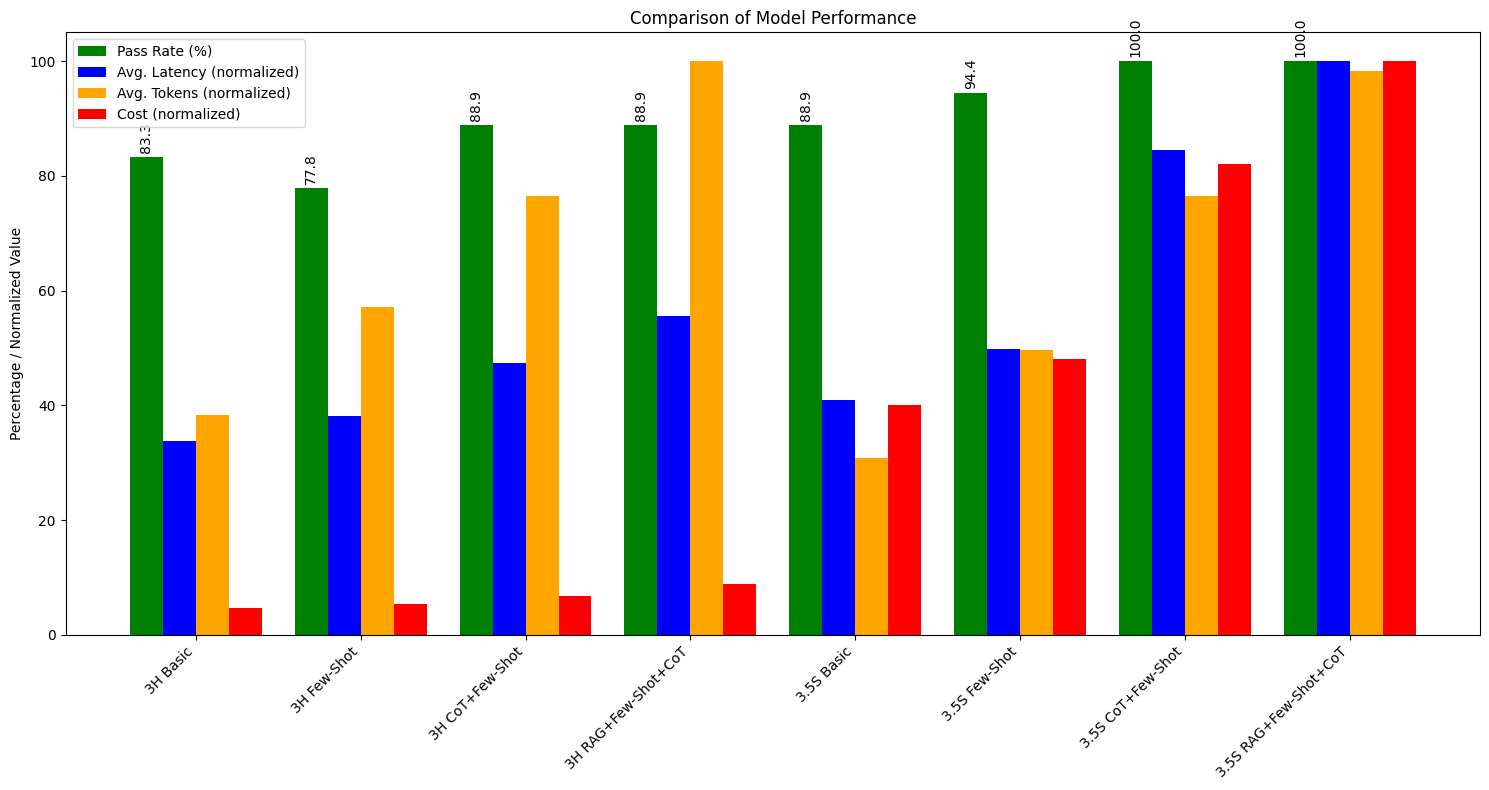

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['3H Basic', '3H Few-Shot', '3H CoT+Few-Shot', '3H RAG+Few-Shot+CoT',
          '3.5S Basic', '3.5S Few-Shot', '3.5S CoT+Few-Shot', '3.5S RAG+Few-Shot+CoT']
pass_rates = [83.3, 77.8, 88.9, 88.9, 88.9, 94.4, 100, 100]
avg_latencies = [1561, 1758, 2187, 2564, 1887, 2297, 3900, 4614]
avg_tokens = [383, 572, 765, 1001, 309, 496, 765, 984]
costs = [0.0023, 0.0027, 0.0034, 0.0044, 0.020, 0.024, 0.041, 0.050]

# Normalize the data
max_latency = max(avg_latencies)
max_tokens = max(avg_tokens)
max_cost = max(costs)
norm_latencies = [l/max_latency*100 for l in avg_latencies]
norm_tokens = [t/max_tokens*100 for t in avg_tokens]
norm_costs = [c/max_cost*100 for c in costs]

# Set up the plot
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(15, 8))

# Create the bars
ax.bar(x - 1.5*width, pass_rates, width, label='Pass Rate (%)', color='green')
ax.bar(x - 0.5*width, norm_latencies, width, label='Avg. Latency (normalized)', color='blue')
ax.bar(x + 0.5*width, norm_tokens, width, label='Avg. Tokens (normalized)', color='orange')
ax.bar(x + 1.5*width, norm_costs, width, label='Cost (normalized)', color='red')

# Customize the plot
ax.set_ylabel('Percentage / Normalized Value')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

add_labels(ax.containers[0])  # Only add labels for pass rates

plt.tight_layout()
plt.show()

### Running Promptfoo

You can run an evaluation with the command `promptfoo eval`. You can render the eval results via the command `promptfoo view`. Here's a preview of what the results look like:

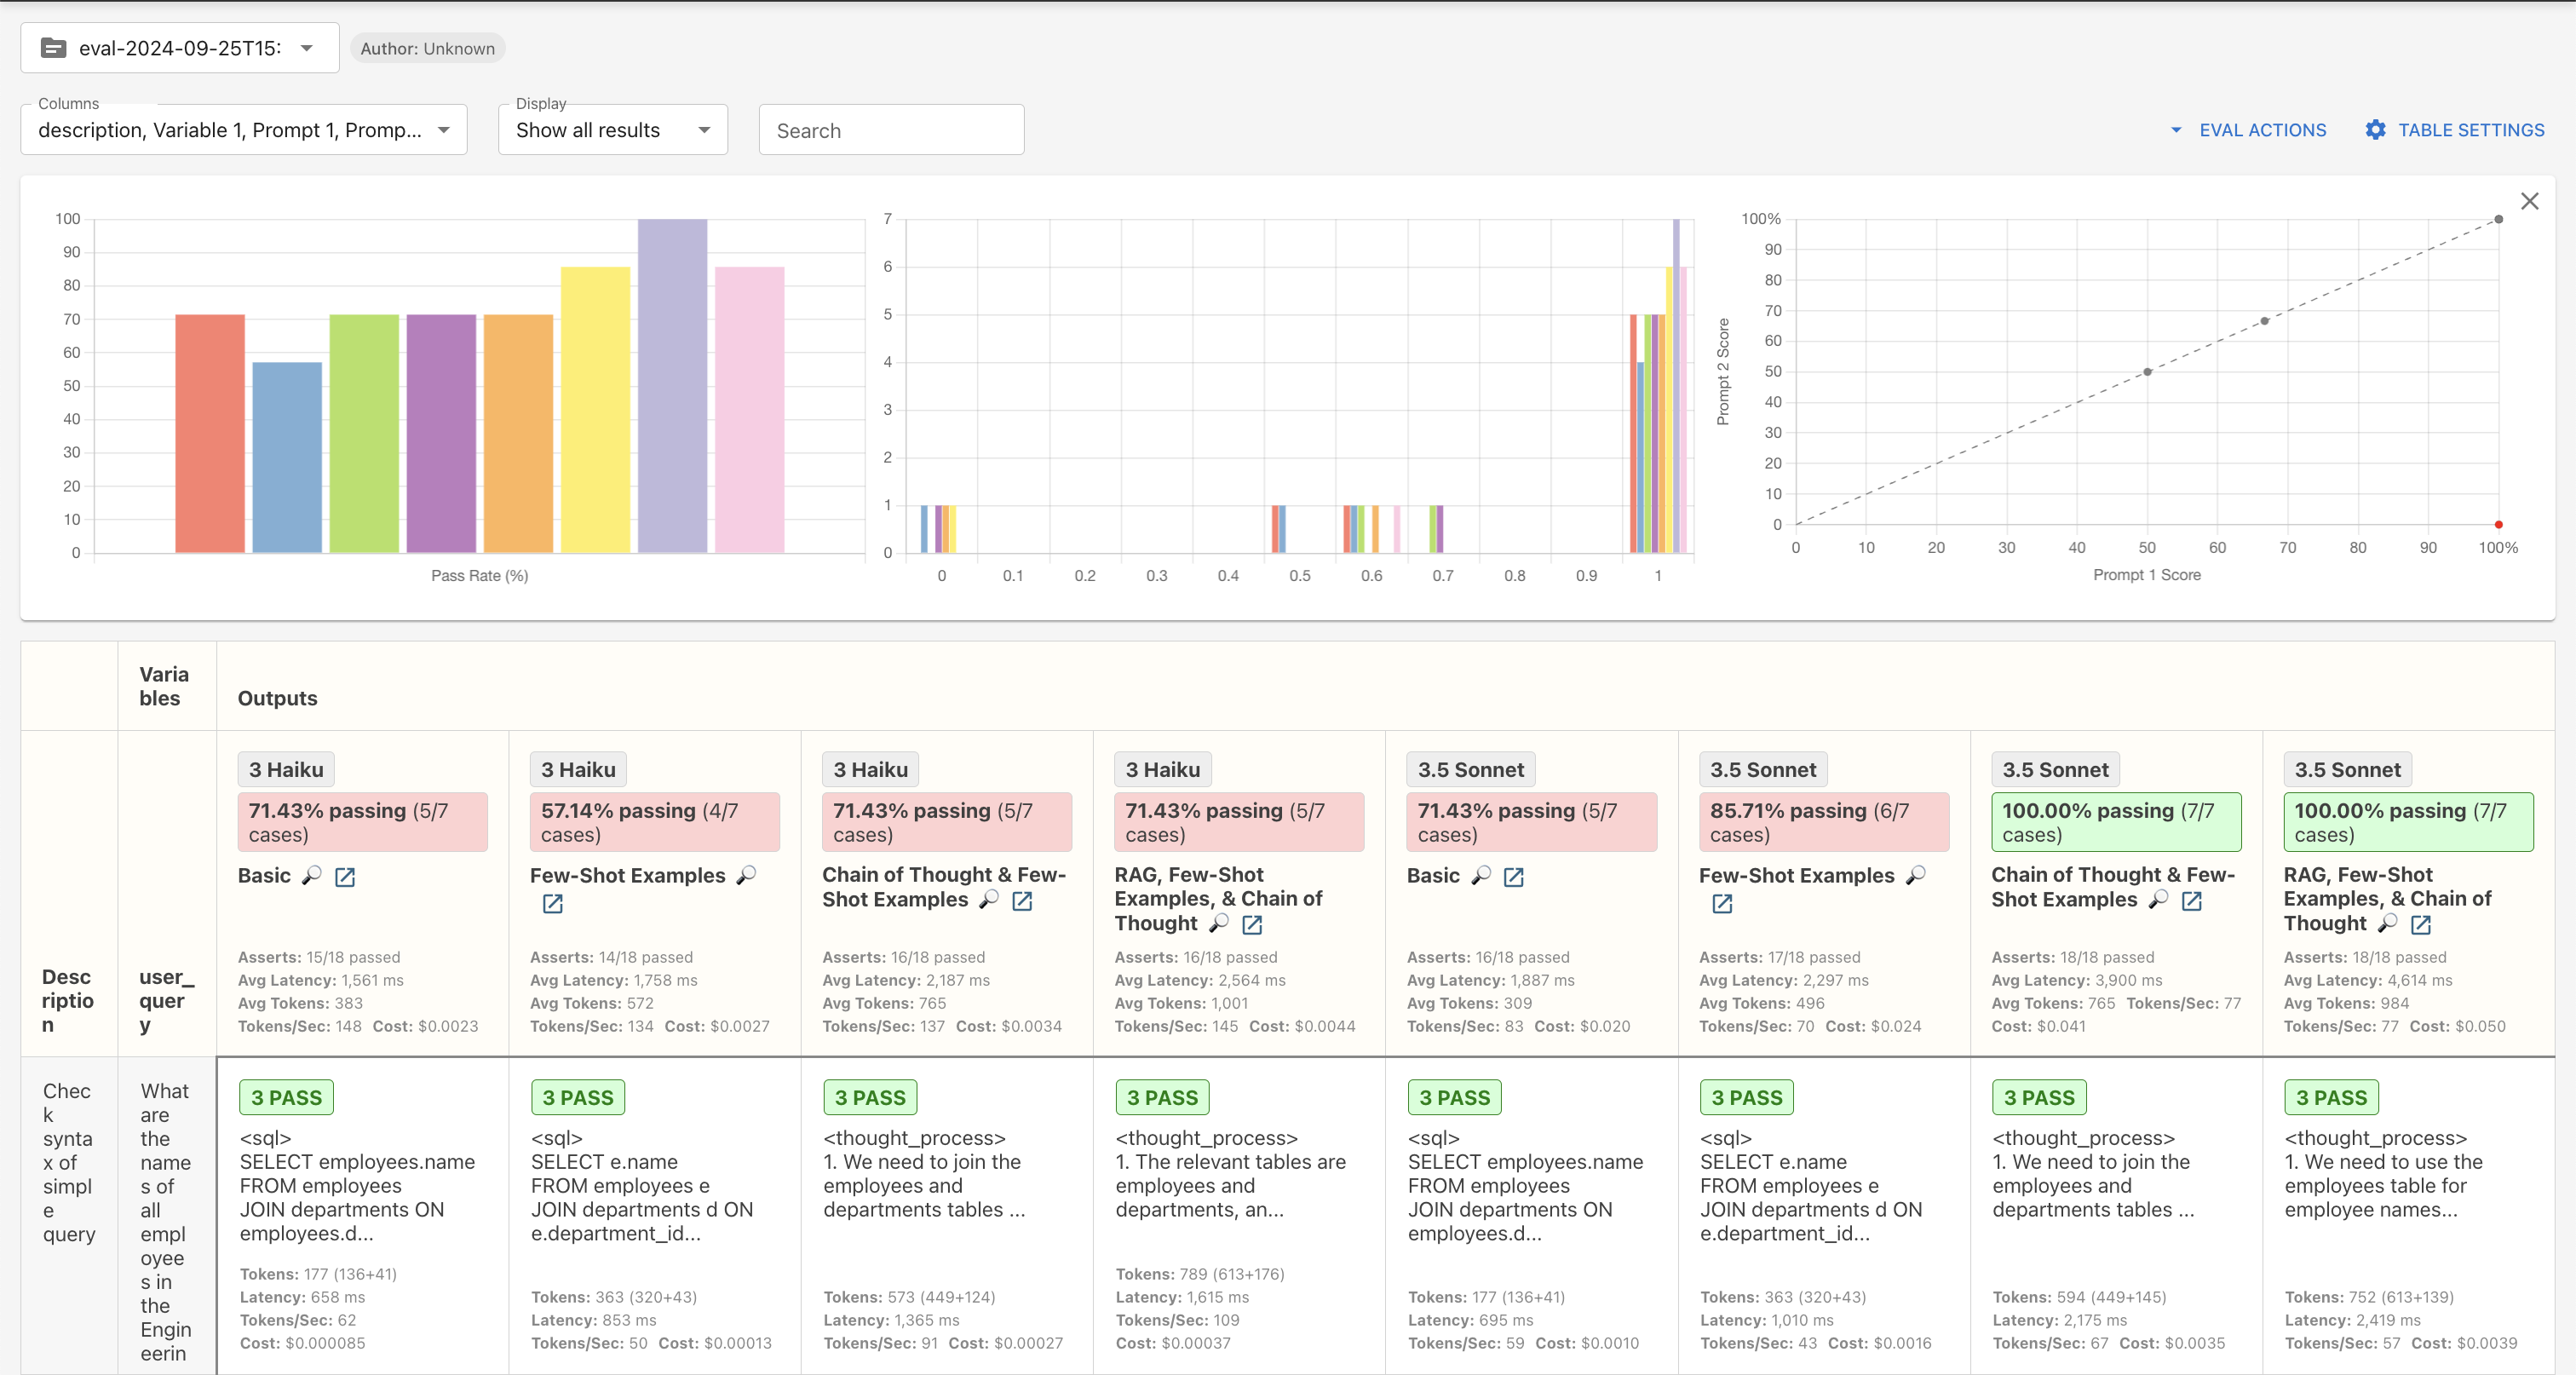
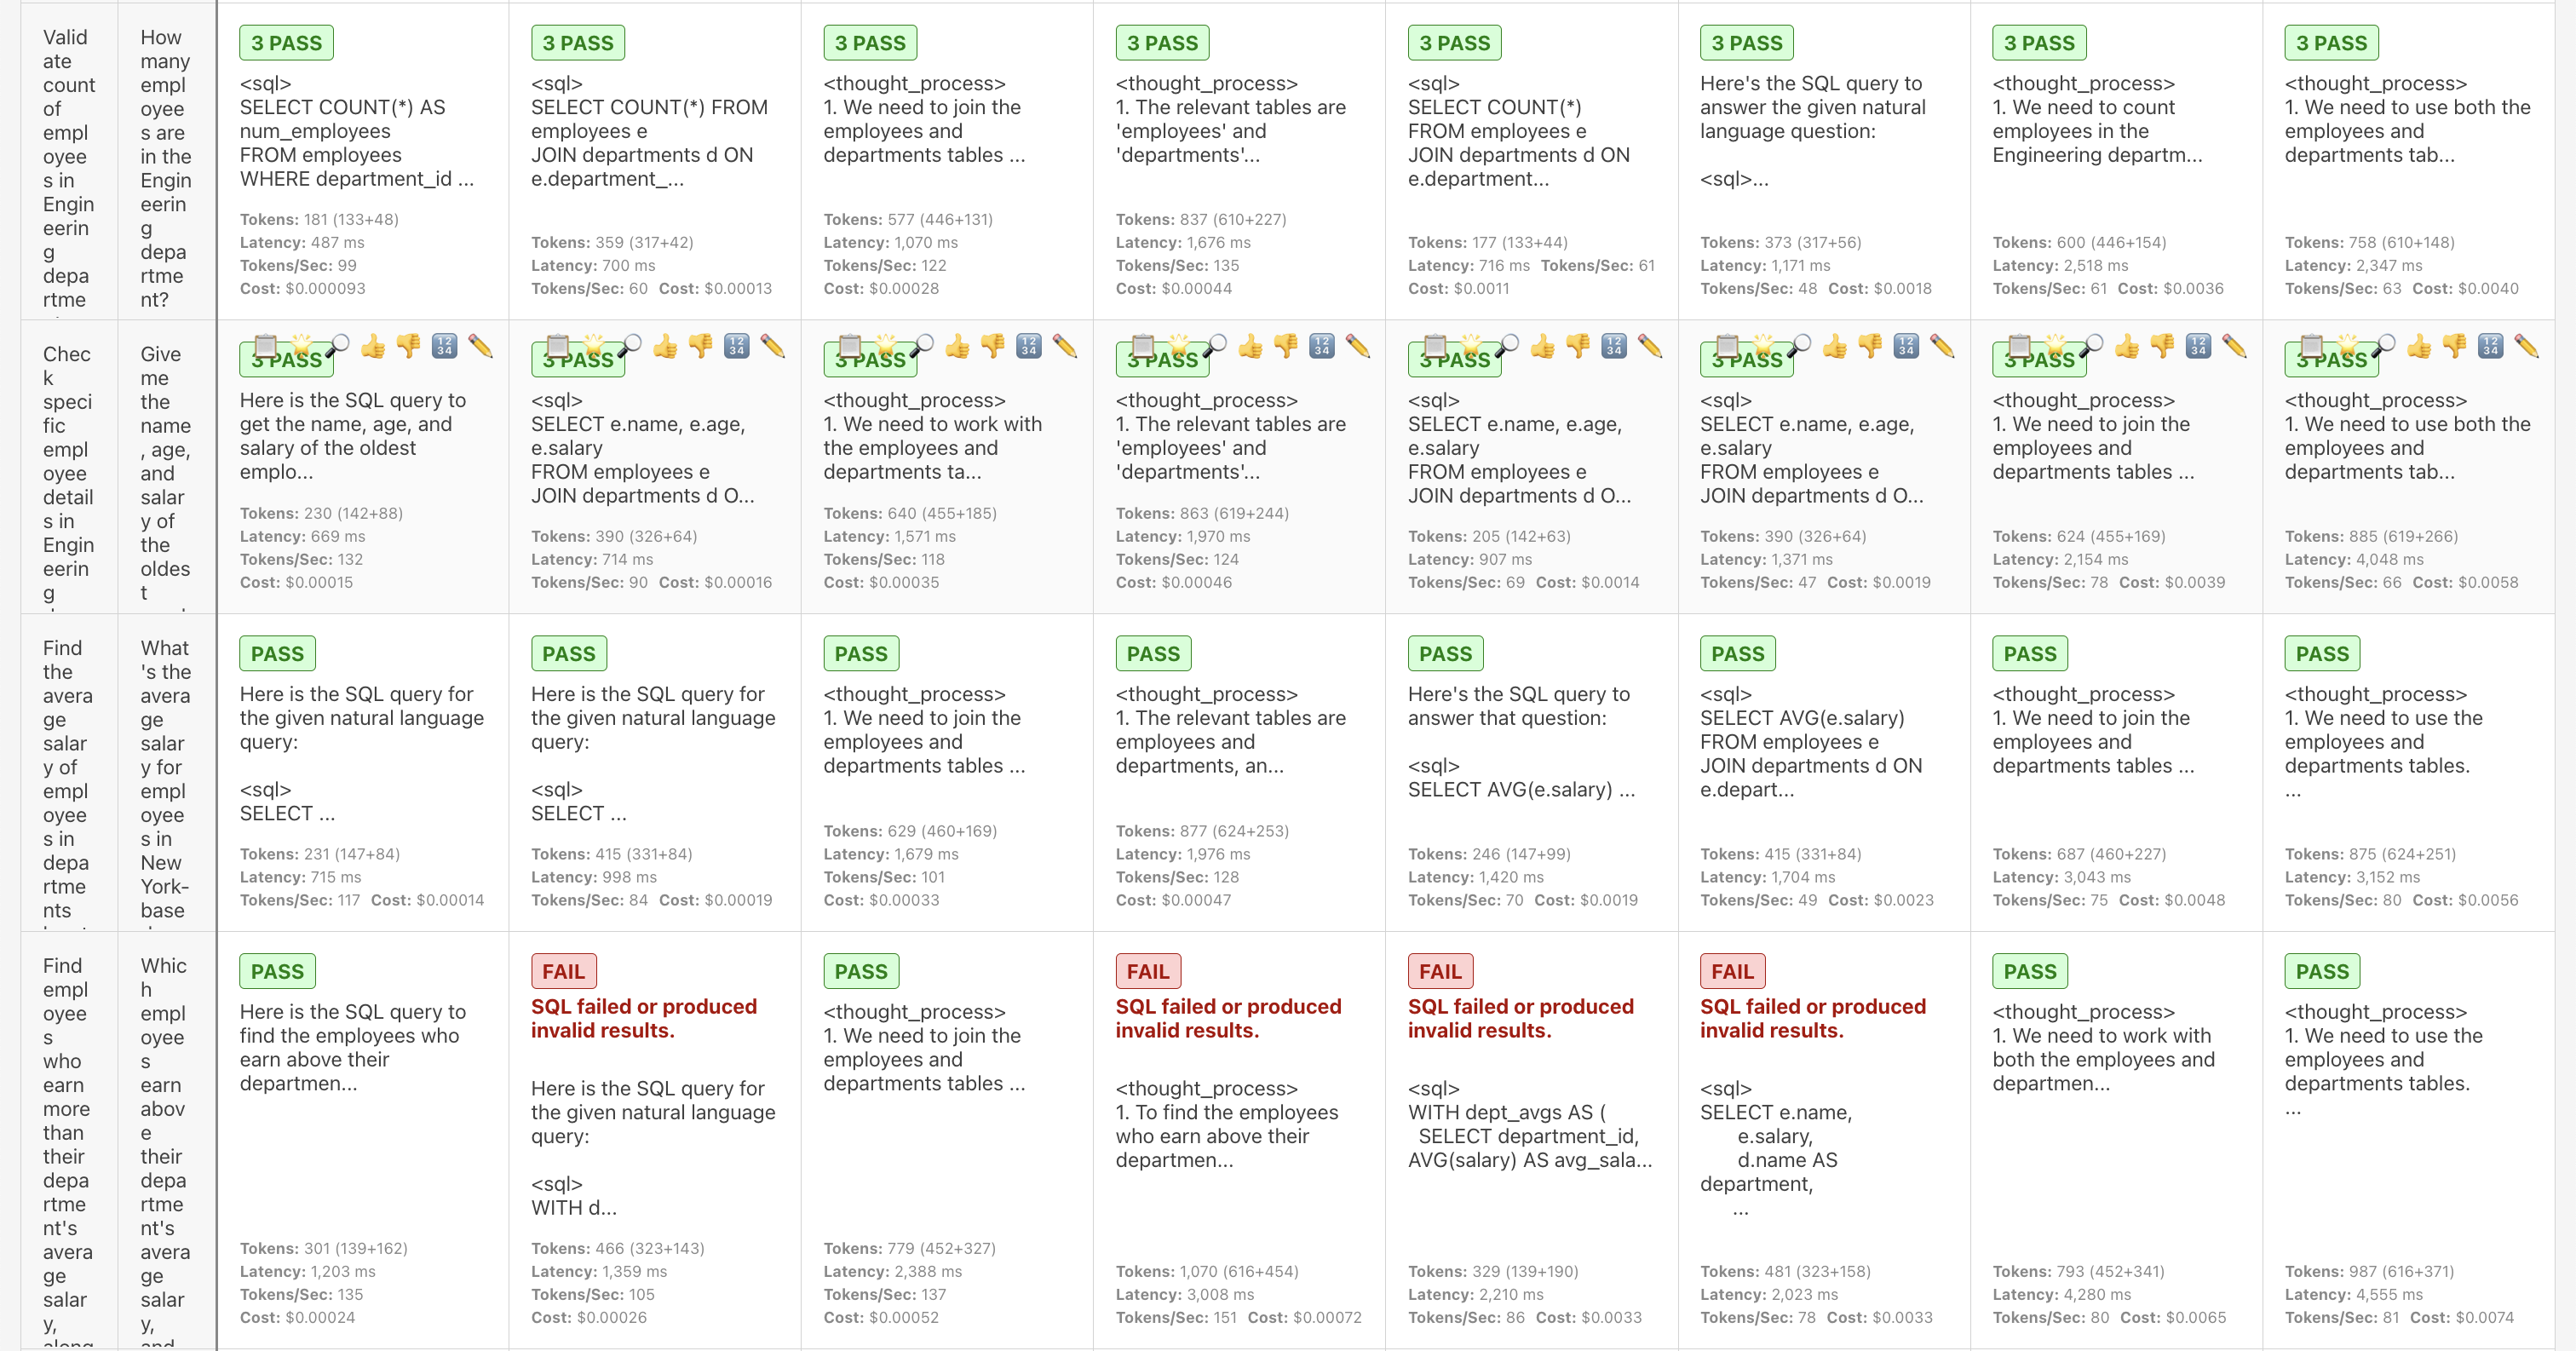
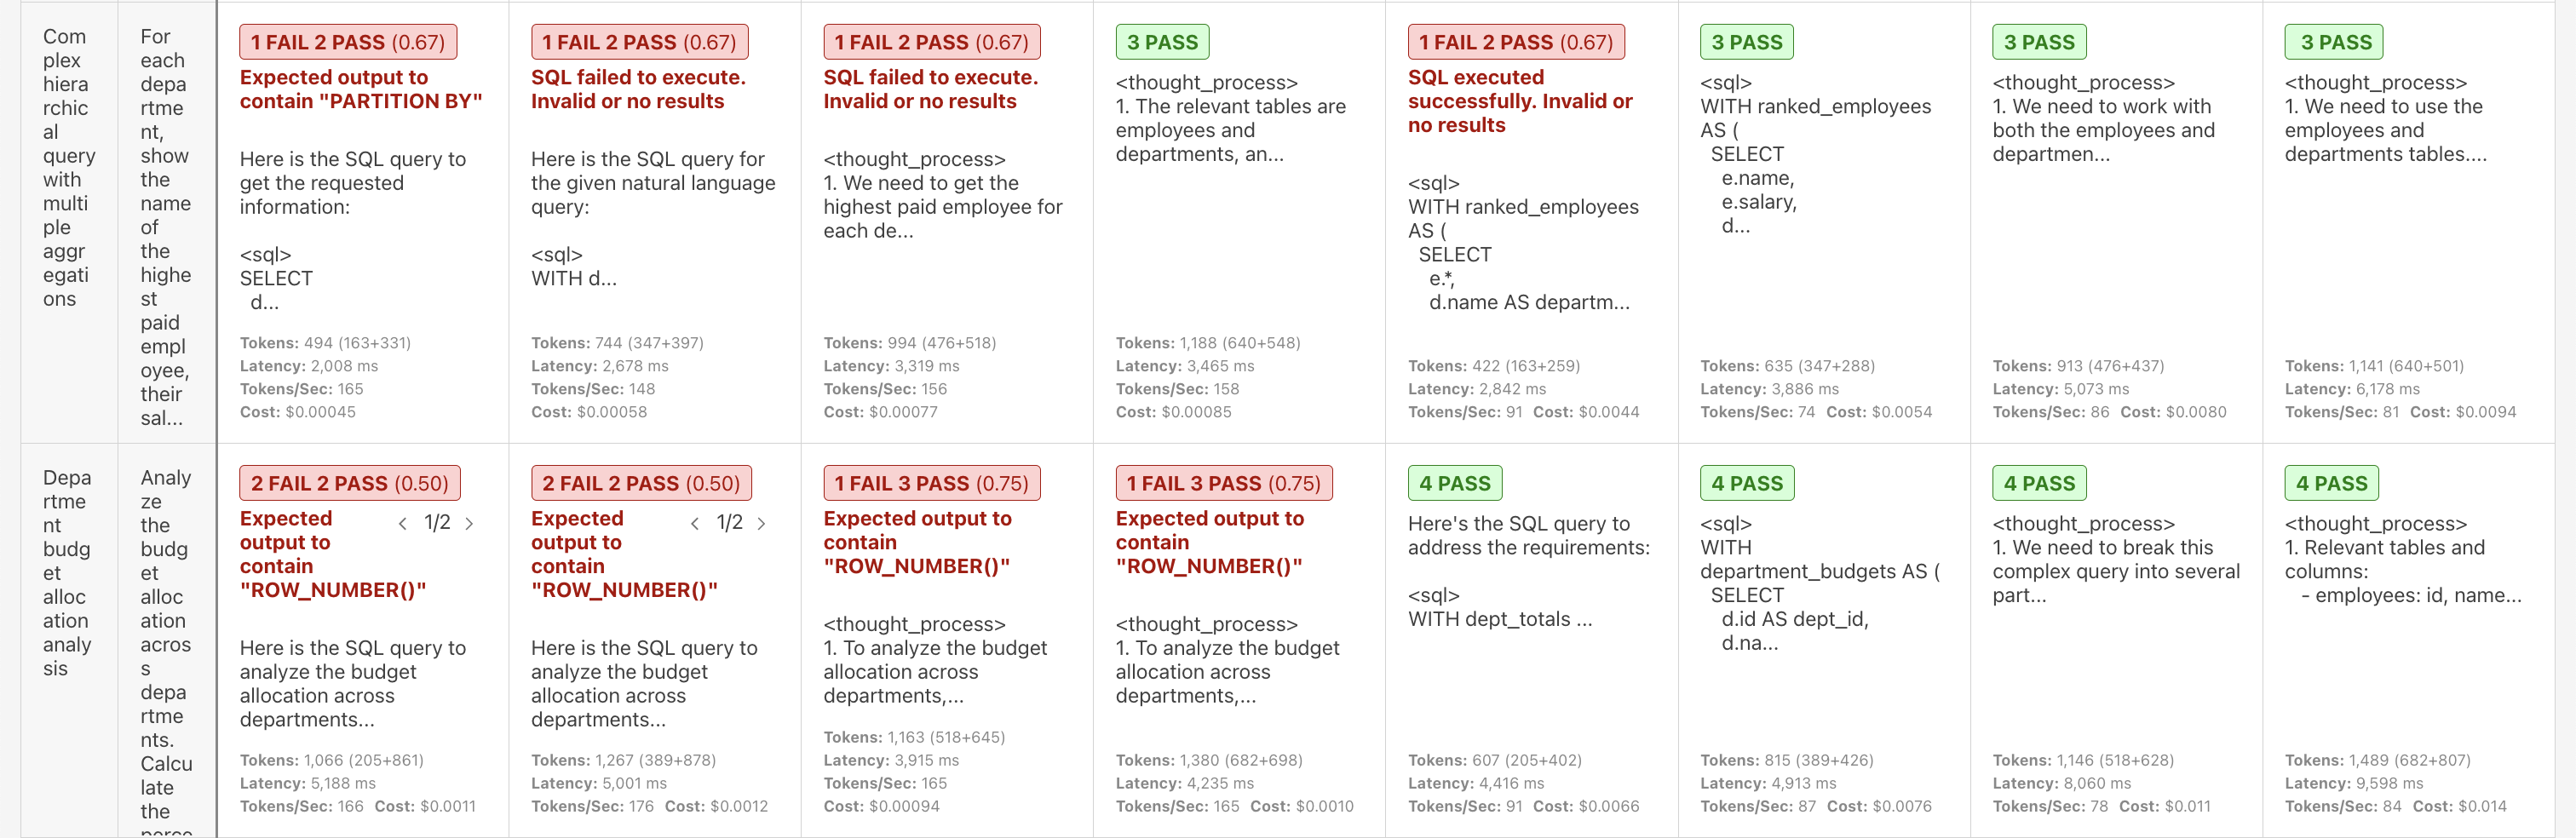

## Further Exploration & Next Steps

This guide covers the basics of building a Text-to-SQL system with Claude. Here are some directions to explore that can help improve your solution:

### Refining Retrieval Performance

As databases grow, it's important to make sure your RAG system finds the most relevant and current information:

1. **Recent usage filter**: Focus on actively-maintained and fresh data by only including tables in the RAG lookup that have been queried a certain number of times in a set timeframe.

2. **Query frequency ranking**: Prioritize more commonly-used data by ranking RAG results based on how often tables are queried in production.

3. **Regular updates**: Set up a system to update your vector database when schemas change, keeping it current with your database.

4. **Context-aware embeddings**: Try embedding table relationships and usage patterns, along with their names, to improve search relevance.

### Adding More Context to Prompts

Giving Claude more information about your data structure and content in prompts, in addition to database schemas, can help it generate better queries:

1. **Data samples**: Include a few rows of actual data for each relevant table in your prompts. For example:

```
<data_sample>
Sample data for employees table:
id | name         | age | department_id | salary  | hire_date
1  | John Doe     | 35  | 2             | 75000.0 | 2020-01-15
2  | Jane Smith   | 28  | 3             | 65000.0 | 2021-03-01
</data_sample>
```

2. **Column statistics**: Add useful facts about each column, such as:
   - Percentage of empty values
   - Lowest and highest values for number columns
   - Most common values for category columns

3. **Data quality notes**: Mention any known issues or special cases with specific columns or tables.

4. **Data catalog information**: If you use tools like dbt to manage your data, include relevant details from your data catalog:
   - Table overviews from dbt .yml files
   - Column explanations, including calculations or business rules
   - Table relationships and data lineage
   - Data quality checks and expectations
   - Update frequency for time-sensitive queries

5. **Business context**: Add information about how the data is used in your organization, common types of analyses performed, or important business metrics derived from the data.